# Урок 4. Кейс 1. Построение и оценка модели

## Домашнее задание 4

***Вариант 1***

**1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.**

In [1]:
import numpy as np
import pandas as pd 

import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

d:\Users\Tim\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

In [3]:
data.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000,145374.000000
mean,32079.773047,2009.801340,6.435979,15.722681,2.481241,180.459835,26.218643,2.999168,11.501101,0.027233,0.027075,0.027240
std,6464.167501,4.791885,3.438982,8.801258,1.114448,105.138073,15.019836,1.999572,6.921927,0.162763,0.162303,0.162783
min,14544.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27573.000000,2006.000000,3.000000,8.000000,1.000000,90.000000,13.000000,1.000000,6.000000,0.000000,0.000000,0.000000
50%,31421.000000,2010.000000,6.000000,16.000000,2.000000,179.000000,26.000000,3.000000,12.000000,0.000000,0.000000,0.000000
75%,35648.750000,2014.000000,9.000000,23.000000,3.000000,271.000000,39.000000,5.000000,18.000000,0.000000,0.000000,0.000000
max,62009.000000,2018.000000,12.000000,31.000000,4.000000,366.000000,53.000000,6.000000,23.000000,1.000000,1.000000,1.000000


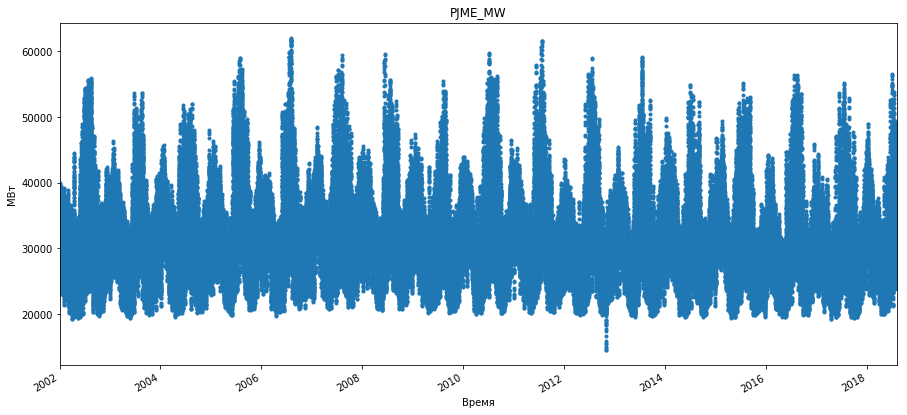

In [4]:
_ = data['PJME_MW'].plot(style='.', figsize=(15, 7), title='PJME_MW')
plt.xlabel('Время')
plt.ylabel('МВт');

In [5]:
df_week = data.resample('W').mean()

df_week.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


In [6]:
df_week.describe()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
count,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000
mean,32081.930877,2009.803365,6.435416,15.720369,2.481181,180.440136,26.215935,2.998533,11.501072,0.027240,0.027054,0.027248
std,3982.384374,4.797106,3.381168,6.828859,1.098205,103.247833,15.027629,0.053246,0.013025,0.056181,0.056005,0.056201
min,24577.173653,2002.000000,1.000000,3.517483,1.000000,3.517483,1.000000,1.525773,11.381443,0.000000,0.000000,0.000000
25%,28791.333333,2006.000000,3.607143,10.000000,1.607143,91.986527,13.000000,3.000000,11.500000,0.000000,0.000000,0.000000
50%,31424.488095,2010.000000,6.071429,16.000000,2.214286,178.500000,26.000000,3.000000,11.500000,0.000000,0.000000,0.000000
75%,34817.644345,2014.000000,9.000000,21.142857,3.000000,269.000000,39.000000,3.000000,11.500000,0.000000,0.000000,0.000000
max,46761.494048,2018.000000,12.000000,28.000000,4.000000,362.000000,53.000000,3.517483,11.580420,0.160839,0.142857,0.167832


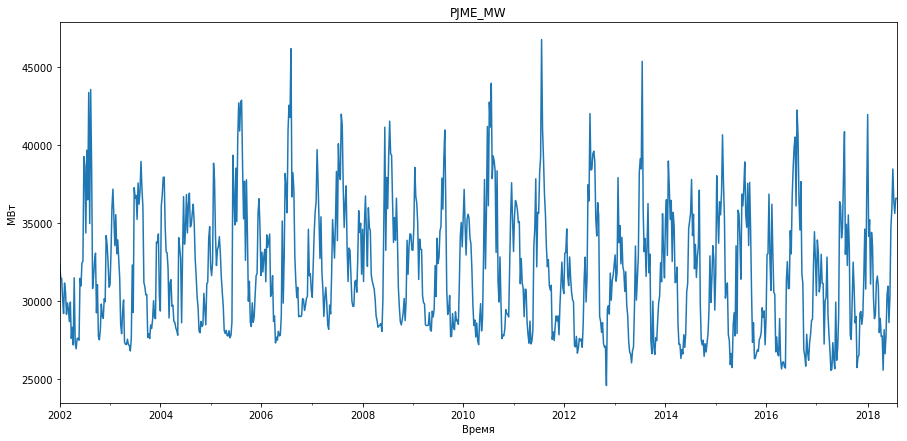

In [7]:
_ = df_week['PJME_MW'].plot(style='-', figsize=(15, 7), title='PJME_MW')
plt.xlabel('Время')
plt.ylabel('МВт');

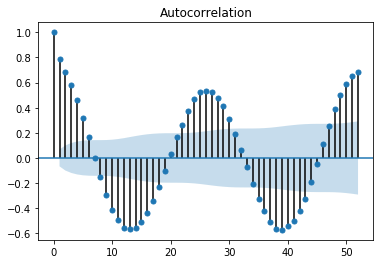

In [8]:
# отобразим автокорреляцию
sm.graphics.tsa.plot_acf(df_week['PJME_MW'].values, lags=52);

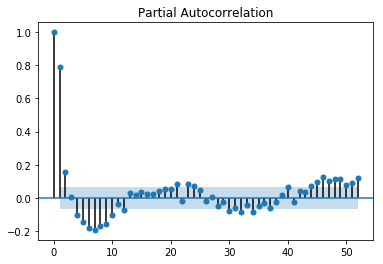

In [9]:
# отобразим частичную автокорреляцию
sm.graphics.tsa.plot_pacf(df_week['PJME_MW'].values, lags=52);

In [10]:
# добавим историю на глубину в 5 дней
p = 5
for i in range(p):
    df_week['t'+str(p-i)]=0
    df_week['t'+str(p-i)].values[p:] = df_week['PJME_MW'].values[i:-(p)+i]

Добавим новых признаков, описывающих содержание ряда. К таким признакам можно отнести разности ряда и разнообразные варианты сглаживания. Добавим к нашей модели 1-е разности. При этом следует помнить, что такие операции уменьшают общую длину корректной выборки на 1, т.е. первую строку данных следует исключить из модели в момент обучения.

In [11]:
first_diff =np.array(df_week.iloc[1:,0].values - df_week.iloc[:-1,0].values).astype('float32') 
df_week['diff1'] = 0
df_week['diff1'] =  df_week['diff1'].astype('float') 
df_week['diff1'].values[1:] = first_diff

In [12]:
# добавим разности на глубину 5
p = 5
for i in range(p):
    df_week['d'+str(p-i)]=0
    df_week['d'+str(p-i)].values[p:] = df_week['diff1'].values[i:-(p)+i]

In [13]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [14]:
df_week['exp_0_01'] = exponential_smoothing(df_week['PJME_MW'], 0.01)
df_week['exp_0_03'] = exponential_smoothing(df_week['PJME_MW'], 0.03)
df_week['exp_0_04'] = exponential_smoothing(df_week['PJME_MW'], 0.04)
df_week['exp_0_06'] = exponential_smoothing(df_week['PJME_MW'], 0.06)
df_week['exp_0_07'] = exponential_smoothing(df_week['PJME_MW'], 0.07)
df_week['exp_0_08'] = exponential_smoothing(df_week['PJME_MW'], 0.08)

In [15]:
df_week.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,...,d4,d3,d2,d1,exp_0_01,exp_0_03,exp_0_04,exp_0_06,exp_0_07,exp_0_08
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,...,0,0,0,0,32392.160839,32392.160839,32392.160839,32392.160839,32392.160839,32392.160839
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,...,0,0,0,0,32383.113100,32365.017621,32355.969882,32337.874403,32328.826664,32319.778924
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,...,0,0,0,0,32373.810778,32337.653521,32319.846325,32284.774796,32267.510464,32250.427087
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,...,0,0,0,0,32351.487968,32271.769808,32232.713662,32156.180094,32118.691815,32081.715301
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,...,0,0,0,0,32319.937969,32179.511357,32111.264639,31978.598574,31914.137554,31850.897124


In [16]:
h = 1
X = df_week.iloc[p:-h,:]
X.shape

(860, 29)

In [17]:
y = df_week['PJME_MW'].values[h+p:].reshape((df_week.shape[0]-h-p,1))
y.shape

(860, 1)

In [18]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features');
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

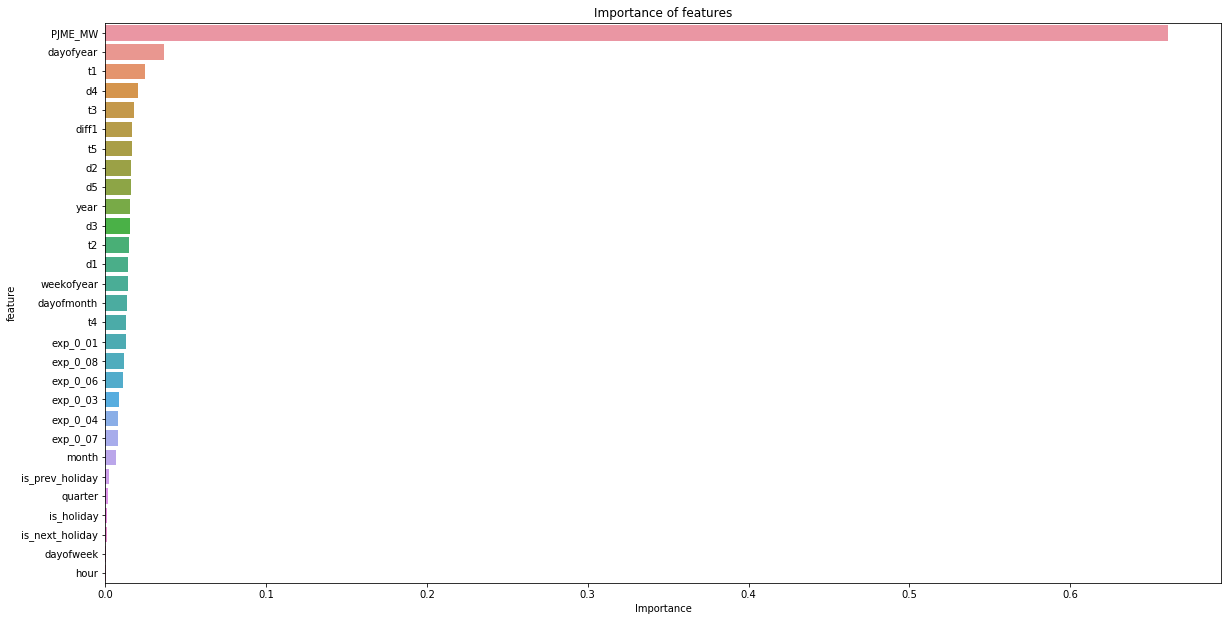

In [19]:
model_rfr = RandomForestRegressor(n_estimators=500, random_state=42, max_depth=20)
model_rfr.fit(X, y)
important_features_top = show_feature_importances(X.columns, model_rfr.feature_importances_, get_top=5)

In [20]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

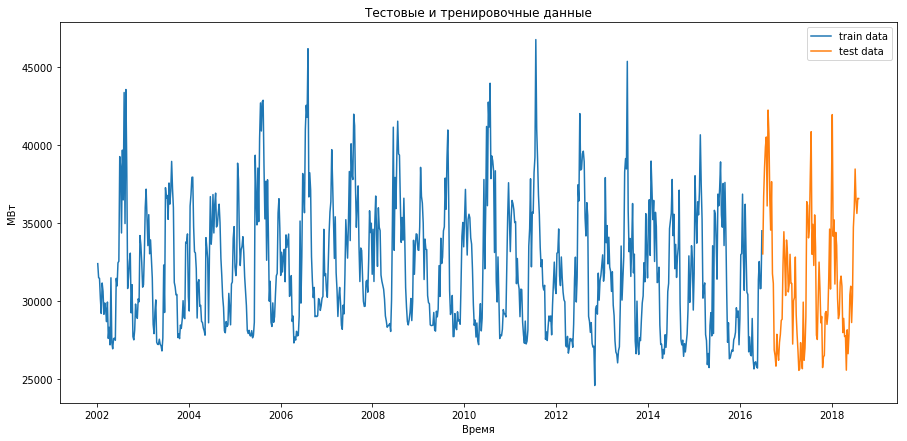

In [21]:
train, test = split_data(df_week[important_features_top], '30-06-2016')

X_train = train.iloc[:-1,:]
y_train = train['PJME_MW'].values[1:]
X_test = test.iloc[:-1,:]
y_test = test['PJME_MW'].values[1:]

X_train_4 = train.iloc[:-4,:]
y_train_4 = train['PJME_MW'].values[4:]
X_test_4 = test.iloc[:-4,:]
y_test_4 = test['PJME_MW'].values[4:]

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend();

**2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков.**

In [22]:
def split_data(data, index, split_date):
    return data.loc[data.index.get_level_values(index) <= split_date].copy(), \
           data.loc[data.index.get_level_values(index) >  split_date].copy()

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

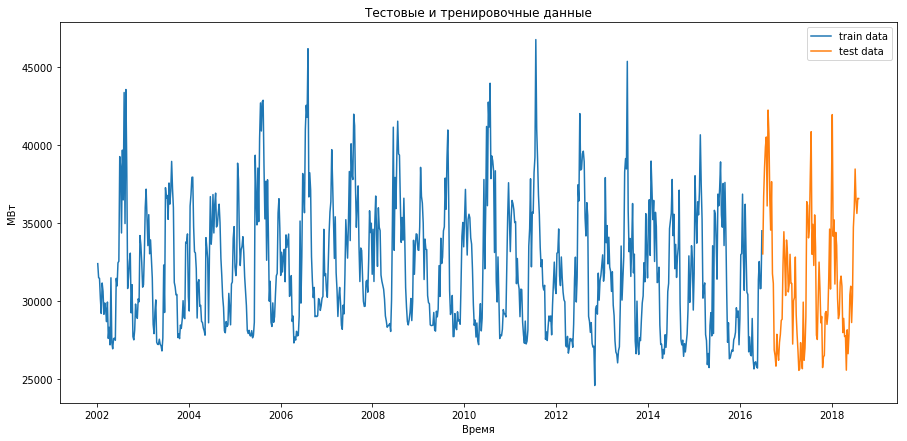

In [25]:
h = 4

X_train = train.iloc[:-h, :]
y_train = train['PJME_MW'].values[h:]
X_test = test.iloc[:-h, :]
y_test = test['PJME_MW'].values[h:]

plt.figure(figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('МВт')
plt.plot(train.index.get_level_values('Date'), train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'), test['PJME_MW'], label='test data')
plt.title('Тестовые и тренировочные данные')
plt.legend();

In [26]:
tss = TimeSeriesSplit(n_splits=5)

estimator = GradientBoostingRegressor(n_estimators=100, random_state=42)

In [27]:
X_train_, X_test_ = X_train.loc[:, important_features_top], X_test.loc[:, important_features_top]

regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)

params = {'n_estimators': np.array(range(10, 110, 10)),
          'max_depth': np.array(range(2, 7, 1))
}

search = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_squared_error', cv=tss, n_jobs=1)

search.fit(X_train_, y_train)

search.best_params_

{'max_depth': 2, 'n_estimators': 100}

Для h = 4
MSE: 7304270.8831
MAE: 2099.2736
R^2: 0.5559
MAPE: 6.7938%
RMSE: 2702.6415


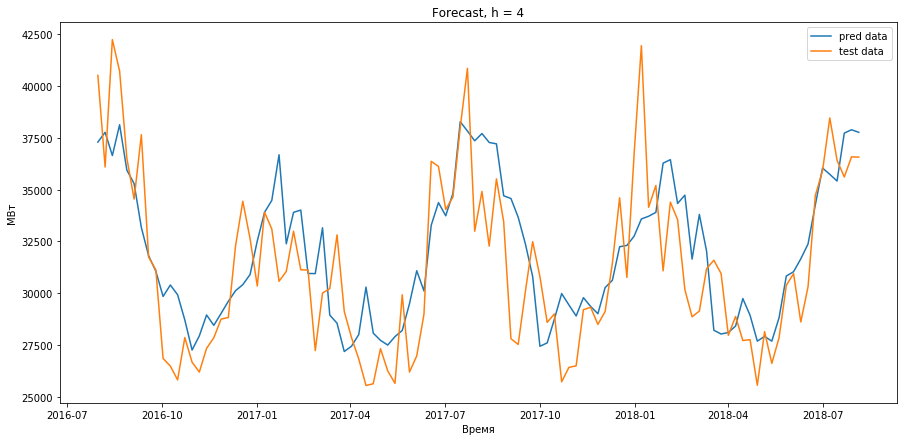

In [28]:
search.best_estimator_.fit(X_train_, y_train) 

y_test_pred = search.best_estimator_.predict(X_test_)

plt.figure(figsize=(15, 7))

plt.title('Forecast, h = 4')

plt.xlabel('Время')
plt.ylabel('МВт')
plt.plot(test.index[h:], y_test_pred, label='pred data')
plt.plot(test.index[h:], y_test, label='test data')

plt.legend();

print('Для h = 4')
print(f'MSE: {np.round(mean_squared_error(y_test, y_test_pred), 4)}')
print(f'MAE: {np.round(mean_absolute_error(y_test, y_test_pred), 4)}')
print(f'R^2: {np.round(r2_score(y_test, y_test_pred), 4)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(y_test, y_test_pred), 4)}%')
print(f'RMSE: {np.round(root_mean_squared_error(y_test, y_test_pred), 4)}')

**3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.**

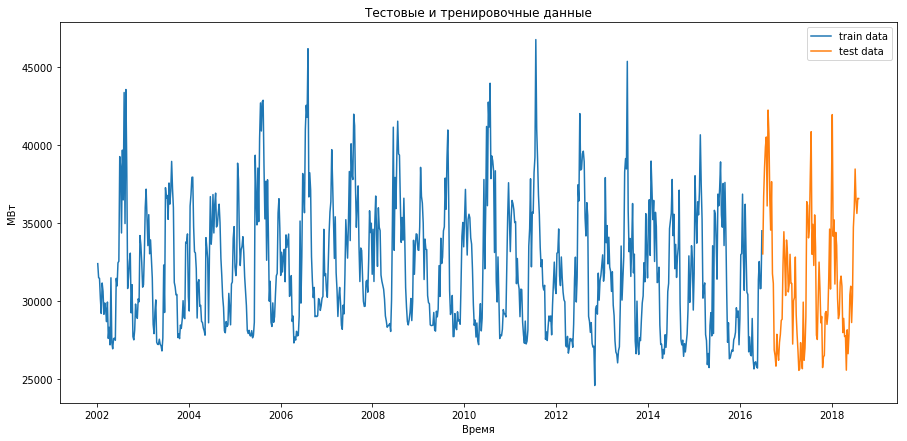

In [29]:
h = 1

X_train = train.iloc[:-h, :]
y_train = train['PJME_MW'].values[h:]
X_test = test.iloc[:-h, :]
y_test = test['PJME_MW'].values[h:]

plt.figure(figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('МВт')
plt.plot(train.index.get_level_values('Date'), train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'), test['PJME_MW'], label='test data')
plt.title('Тестовые и тренировочные данные')
plt.legend();

In [30]:
X_train_, X_test_ = X_train.loc[:, important_features_top], X_test.loc[:, important_features_top]

regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)

params = {'n_estimators': np.array(range(10, 110, 10)),
          'max_depth': np.array(range(2, 7, 1))
}

search = GridSearchCV(regressor, param_grid=params, scoring='neg_mean_squared_error', cv=tss, n_jobs=1)

search.fit(X_train_, y_train)

search.best_params_

{'max_depth': 2, 'n_estimators': 60}

Для h = 1
MSE: 5985040.8453
MAE: 1895.6038
R^2: 0.6558
MAPE: 5.9914%
RMSE: 2446.4343


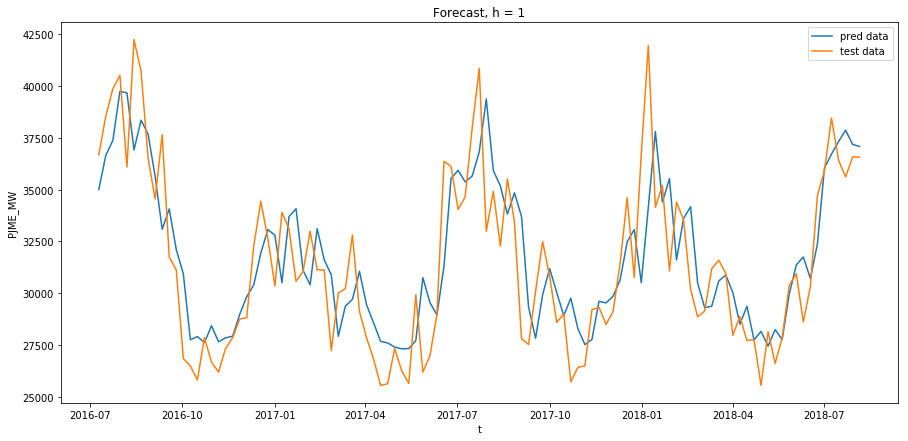

In [31]:
search.best_estimator_.fit(X_train_, y_train) 

y_test_pred = search.best_estimator_.predict(X_test_)

plt.figure(figsize=(15, 7))

plt.title('Forecast, h = 1')

plt.xlabel('t')
plt.ylabel('PJME_MW')
plt.plot(test.index[h:], y_test_pred, label='pred data')
plt.plot(test.index[h:], y_test, label='test data')

plt.legend();

print('Для h = 1')
print(f'MSE: {np.round(mean_squared_error(y_test, y_test_pred), 4)}')
print(f'MAE: {np.round(mean_absolute_error(y_test, y_test_pred), 4)}')
print(f'R^2: {np.round(r2_score(y_test, y_test_pred), 4)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(y_test, y_test_pred), 4)}%')
print(f'RMSE: {np.round(root_mean_squared_error(y_test, y_test_pred), 4)}')

**4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.**

In [32]:
h = 4

X_train = train.iloc[:-h, :]
y_train = train['PJME_MW'].values[h:]
X_test = test.iloc[:-h, :]
y_test = test['PJME_MW'].values[h:]

X_train_, X_test_ = X_train.loc[:, important_features_top], X_test.loc[:, important_features_top]

regressor = GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42)

regressor.fit(X_train_, y_train) 

y_test_pred = regressor.predict(X_test_)

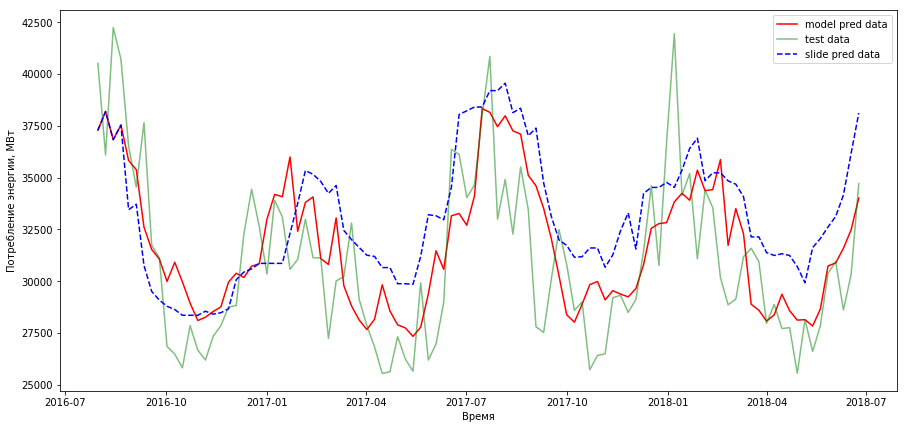

In [33]:
X_test_slide = X_test_.copy()
y_test_slide = y_test_pred.copy()

n = 100

for i in range(n):
    
    y_test_slide[i] = regressor.predict(np.nan_to_num(X_test_slide.iloc[i, :].values.reshape(-1, len(important_features_top))).astype('float64'))

    X_test_slide.iloc[i+h, 0] = y_test_slide[i]
        
    X_test_slide.iloc[i+h, 2] = float(np.mean(X_test_slide.iloc[i+h-26:i+h, 0]))
    
    if i > p:
        
        X_test_slide.iloc[i+h, 3] = X_test_slide.values[i+h-11, 0].astype('int64')
        X_test_slide.iloc[i+h, 4] = X_test_slide.values[i+h-10, 0].astype('int64')
        
plt.figure(figsize=(15, 7))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h:n+h], y_test_pred[:n], 'r',label='model pred data' )
plt.plot(test.index[h:n+h], y_test[:n], 'g',label='test data', alpha=0.5)
plt.plot(test.index[h:n+h], y_test_slide[:n], '--b',label='slide pred data')

plt.legend();

In [34]:
print('Прямое моделирование (h = 4)')
print(f'MSE: {np.round(mean_squared_error(y_test[:n], y_test_pred[:n]), 4)}')
print(f'MAE: {np.round(mean_absolute_error(y_test[:n], y_test_pred[:n]), 4)}')
print(f'R^2: {np.round(r2_score(y_test[:n], y_test_pred[:n]), 4)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(y_test[:n], y_test_pred[:n]), 4)}%')
print(f'RMSE: {np.round(root_mean_squared_error(y_test[:n], y_test_pred[:n]), 4)}')

Прямое моделирование (h = 4)
MSE: 7547910.222
MAE: 2150.5302
R^2: 0.5157
MAPE: 7.0092%
RMSE: 2747.346


In [35]:
print('Рекурсивное моделирование (h = 4)')
print(f'MSE: {np.round(mean_squared_error(y_test[:n], y_test_slide[:n]), 4)}')
print(f'MAE: {np.round(mean_absolute_error(y_test[:n], y_test_slide[:n]), 4)}')
print(f'R^2: {np.round(r2_score(y_test[:n], y_test_slide[:n]), 4)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(y_test[:n], y_test_slide[:n]), 4)}%')
print(f'RMSE: {np.round(root_mean_squared_error(y_test[:n], y_test_slide[:n]), 4)}')

Рекурсивное моделирование (h = 4)
MSE: 14036807.2862
MAE: 3211.9972
R^2: 0.0994
MAPE: 10.6847%
RMSE: 3746.5727


Прямое моделирование оказалось получше рекурсивного.

**5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)**

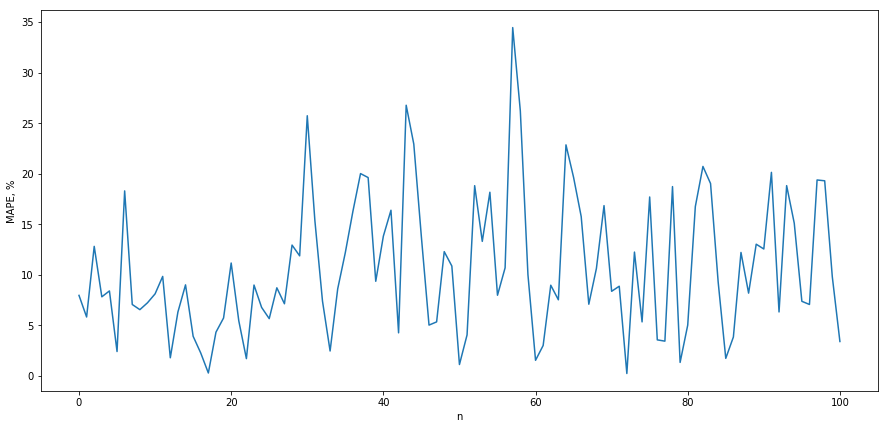

In [43]:
errors = {}

for i in range(101):
    
    errors[i] = np.round(mean_absolute_percentage_error(y_test[i], y_test_slide[i]), 4)
    
errors = pd.DataFrame({'key': list(errors.keys()), 'value': list(errors.values())})

plt.figure(figsize=(15, 7))

plt.xlabel('n')
plt.ylabel('MAPE, %')

plt.plot(errors.key, errors.value);

In [44]:
print(errors.groupby(np.floor(errors.key / 10).values.astype('int64')).value.mean())

0      8.43180
1      5.15193
2      8.03434
3     13.69993
4     13.13704
5     14.47812
6     11.38002
7      7.97532
8     10.97621
9     13.58201
10     3.39370
Name: value, dtype: float64


In [45]:
pvalue = sm.tsa.stattools.adfuller(errors['value'].values, regression='ctt')[1]

print(f'p-value (Тест Дики-Фуллера): {np.round(pvalue, 4)}')

p-value (Тест Дики-Фуллера): 0.0


**6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.**

**Вывод:**
    
    Затрудняюсь сделать однозначный вывод. Похоже на какой-то случайный процесс. Закономерность обнаружить не удалось.